In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, auc,
    precision_score, recall_score, f1_score
)

from imblearn.over_sampling import SMOTE


In [2]:
df = pd.read_csv("UCI_Credit_Card.csv")
df.head()


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [3]:
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

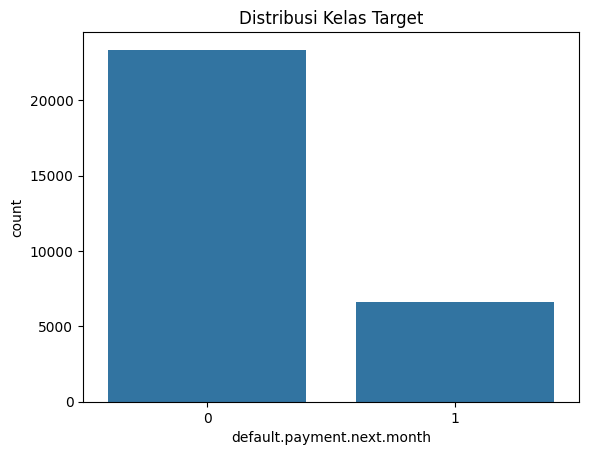

In [4]:
sns.countplot(x="default.payment.next.month", data=df)
plt.title("Distribusi Kelas Target")
plt.show()


In [5]:
df2 = df.drop(columns=["ID"])


In [6]:
X = df2.drop(columns=["default.payment.next.month"])
y = df2["default.payment.next.month"]

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (30000, 23)
y shape: (30000,)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=0,
    stratify=y
)

print("Train:", X_train.shape)
print("Test :", X_test.shape)


Train: (24000, 23)
Test : (6000, 23)


In [8]:
print("Before SMOTE")
print("Default =", sum(y_train == 1))
print("No Default =", sum(y_train == 0))

sm = SMOTE(random_state=0)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("\nAfter SMOTE")
print("Default =", sum(y_train_res == 1))
print("No Default =", sum(y_train_res == 0))


Before SMOTE
Default = 5309
No Default = 18691

After SMOTE
Default = 18691
No Default = 18691


In [9]:
model = XGBClassifier(
    learning_rate=0.1,
    objective="binary:logistic",
    random_state=0,
    eval_metric="mlogloss"
)

model.fit(X_train_res, y_train_res)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [10]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Confusion Matrix:\n", cm)
print("\nAccuracy:", acc)
print("ROC AUC:", roc)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Confusion Matrix:
 [[3863  810]
 [ 631  696]]

Accuracy: 0.7598333333333334
ROC AUC: 0.7512186201383599
Precision: 0.46215139442231074
Recall: 0.5244913338357197
F1 Score: 0.49135192375573594


In [11]:
accuracies = cross_val_score(
    estimator=model,
    X=X_train_res,
    y=y_train_res,
    cv=10
)

print("K-Fold Mean Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))


K-Fold Mean Accuracy: 80.41 %
Standard Deviation: 7.56 %


In [12]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.86      0.83      0.84      4673
           1       0.46      0.52      0.49      1327

    accuracy                           0.76      6000
   macro avg       0.66      0.68      0.67      6000
weighted avg       0.77      0.76      0.77      6000



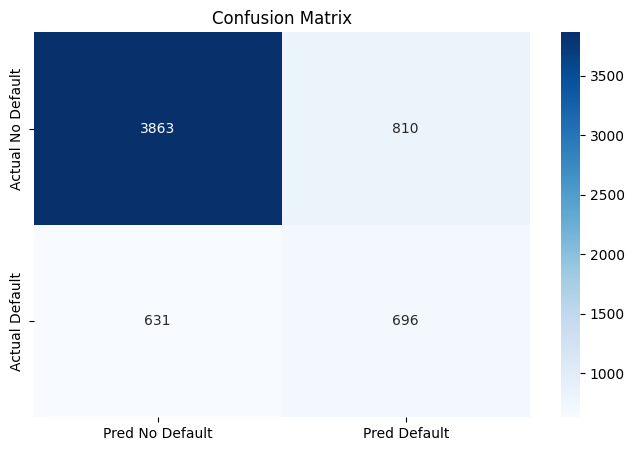

In [13]:
plt.figure(figsize=(8,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Pred No Default", "Pred Default"],
    yticklabels=["Actual No Default", "Actual Default"]
)
plt.title("Confusion Matrix")
plt.show()


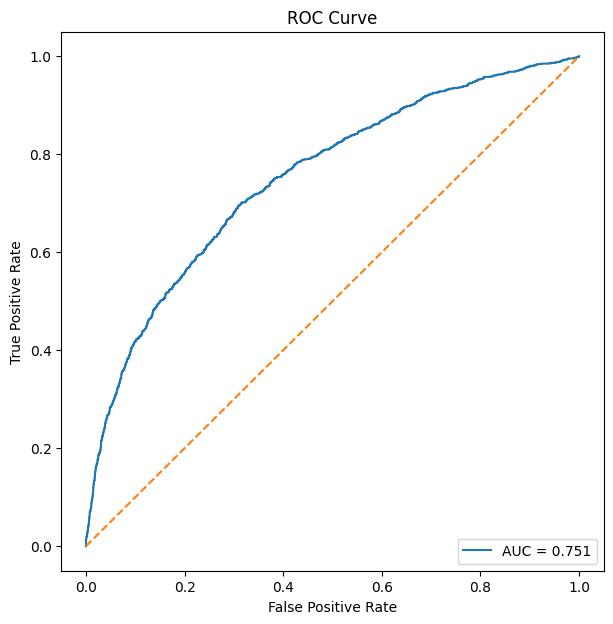

In [14]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, label="AUC = {:.3f}".format(roc_auc))
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.title("ROC Curve")
plt.show()


<Figure size 1000x600 with 0 Axes>

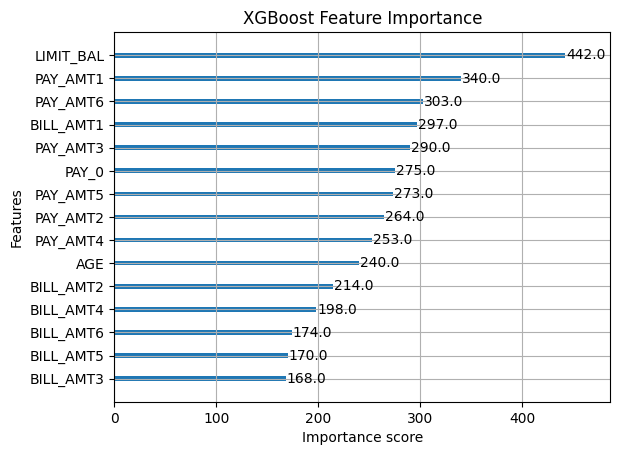

In [15]:
plt.figure(figsize=(10,6))
plot_importance(model, max_num_features=15)
plt.title("XGBoost Feature Importance")
plt.show()


In [16]:
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1]
}

grid = GridSearchCV(
    estimator=XGBClassifier(eval_metric="mlogloss"),
    param_grid=param_grid,
    scoring="accuracy",
    cv=10
)

grid.fit(X_train_res, y_train_res)

print("Best Accuracy:", grid.best_score_)
print("Best Params:", grid.best_params_)


Best Accuracy: 0.8041104486125237
Best Params: {'learning_rate': 0.1}


In [17]:
import pickle

with open("model.pkl", "wb") as file:
    pickle.dump(model, file)
